In [1]:
#SSM FILTER DEMO
#This Jupyterhub is not persistant over the long term. If you want to save changes you've made, do File -> 
# Download as... and share the .ipynb file.

import copy
import random
import re

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
def downloadDatasets(datasets):
    '''
    Download datasets from the remote API.
    
    @param datasets: List of names of datasets to download
    @return: A list of datasets expressed as dictionaries.
    '''
    
    base = {'scidata' : { 
            'system' : {
                'facets' : [
                    {
                        "name": "(+)-(r)-limonene",
                    },
                    {
                        "name": "(+)-(r)-limonene and Chloroform-d",
                        'phase' : ""
                    }
                ]
            },
            'dataset' : {
                'dataseries' : [
                    {
                        'axis' : 'x-axis',
                        'valuearray' : {
                            'numberarray' : [
                                
                            ]
                        }
                    }, 
                    {
                        'axis' : 'y-axis',
                        'valuearray' : {
                            'numberarray' : [
                                
                            ]
                        }
                    }
                ]
            }
    }}
    
    values = []
    
    #Create synthetic data by setting random peaks and phases
    for i in range(500):
        
        value = copy.deepcopy(base)
        
        peak = random.randrange(20000, 50000)
        peak_loc = random.randrange(0, 5000)
        
        if peak_loc < 2500:
            value['scidata']['system']['facets'][1]['phase'] = "sub:solid"
        else:
            value['scidata']['system']['facets'][1]['phase'] = "sub:liquid"
        
        for i in range(5000):
            if i == peak_loc:
                value['scidata']['dataset']['dataseries'][1]['valuearray']['numberarray'].append(peak)
            else:
                value['scidata']['dataset']['dataseries'][1]['valuearray']['numberarray'].append(random.randrange(0,1000))
            value['scidata']['dataset']['dataseries'][0]['valuearray']['numberarray'].append(i - 500)
        
        values.append(value)
        
    return values


In [3]:
class TestFilter:
    '''
    A filter that finds the features and labels in datasets.
    
    '''
    
    def __init__(self):
        '''
        The default constructor
        '''
        self.labelPath = []
        self.featurePaths = []
        
    def getFeatures(self, dicts):
        '''
        Find the features for the given dictionaries.
        
        @param dicts: The dictionaries to extract the feature data for
        @return: A list of lists, where [i][j] corresponds to the jth feature defined in featurePaths for the 
            ith dictionary in dicts
        '''
        features = []
        
        #Find each defined feature
        for path in self.featurePaths:
            features.append(self._getNextSegment(dicts, path))
            
        final_features = []
        
        #Restructure the list so that each sub-list is for all features for a specific dictionary
        for i in range(len(features[0])):
            new_feature = []
            for feature in features:
                new_feature.append(feature[i])
            final_features.append(new_feature)
            
        return final_features
        
    def getLabels(self, dicts):
        '''
        Find the labels for the given dictionaries
        
        @return: A list of labels for each dictionary, in order
        '''
        return self._getNextSegment(dicts, self.labelPath)
        
    def _getNextSegment(self, dicts, path):
        '''
        Recursively traverse through the dictionaries one path segment at a time
        
        @param dicts: The dictionaries to traverse
        @return A list of the values for each dictionary in dicts at the path defined by path, in order
        '''
        
        next_values = []
        
        #SSM: is the flag for special actions in the path
        if path[0].startswith("SSM:"):
            
            #SSM:REG: defines selecting by a regular expression 
            if path[0].startswith("SSM:REG:"):
                tokens = path[0].split(":")
                
                #The key for the value to be matched
                key = tokens[2]
                
                #The regular expression to map
                reg = re.compile(tokens[3])
                
                #For each dictionary, find the sub-dictionaryy in the list such that candidate[key] matches
                #The regex
                for curr_dict in dicts:
                    for candidate in curr_dict:
                        if reg.match(candidate[key]):
                            next_values.append(candidate)
                            break;
            
            #SSM:XY: defines some calculation on XY data
            elif path[0].startswith("SSM:XY:"):
                tokens = path[0].split(":")
                
                #The key where the axis type is defined
                key = tokens[2]
                
                #The operation to be performed
                op = tokens[3]
                
                x_next = []
                y_next = []
                
                #For each dictionary, find the sub-dictionaries in the list for the x and y axes.
                for curr_dict in dicts:
                    
                    for candidate in curr_dict:
                    
                        x_found = False
                        y_found = False

                        if candidate[key] == 'x-axis':
                            x_next.append(candidate)
                            x_found = True
                        elif candidate[key] == 'y-axis':
                            y_next.append(candidate)
                            y_found = True
                            
                        if x_found and y_found:
                            break;
                        
                #Continue the search down for the x and y data
                x = self._getNextSegment(x_next, path[1:])
                y = self._getNextSegment(y_next, path[1:])
                    
                #The PEAK operation finds the highest value in the data
                if op == "PEAK":
                    
                    peaks = []
                    
                    #Find the peak in each series
                    for series in y:
                        
                        peak = series[0]
                        
                        for i in series:
                            if i > peak:
                                peak = i
                                
                        peaks.append(peak)
                        
                    return peaks
                
                #The PEAK-LOC finds the values of x such that y[i] is the maximum y and x = x[i]
                elif op == "PEAK-LOC":
                    
                    peaks = []
                    
                
                    #Find the location of the x where the maximum y is located
                    for i, series in enumerate(y):
                        
                        loc = 0
                        
                        for j in range(len(series)):
                            if series[j] > series[loc]:
                                loc = j
                                
                        peaks.append(x[i][loc])
                        
                    return peaks
            
        else:
            
            #For normal segments, get the value for the first segment
            for curr_dict in dicts:
                next_values.append(curr_dict[path[0]])
                
        #Recursively traverse the dictionaries down for the next segment
        if len(path) == 1:
            return next_values
        else:
            return self._getNextSegment(next_values, path[1:])

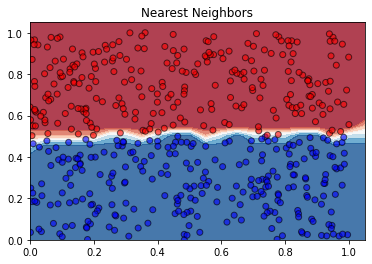

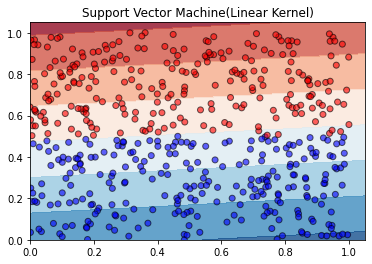

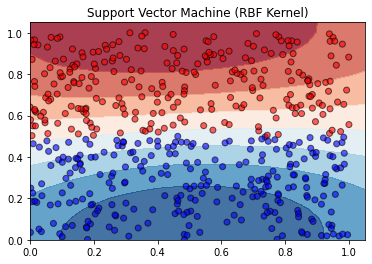

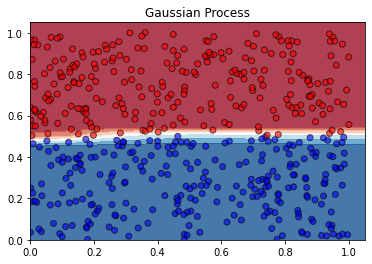

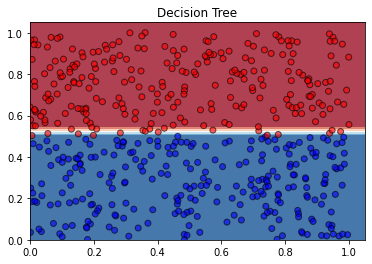

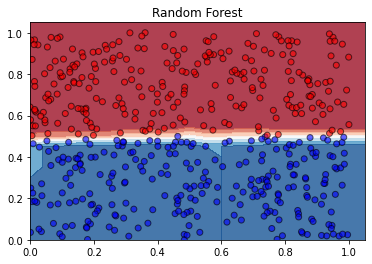

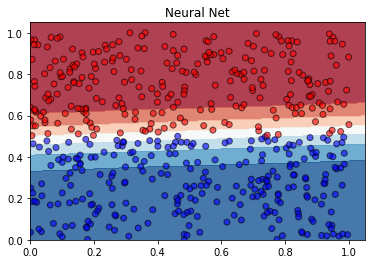

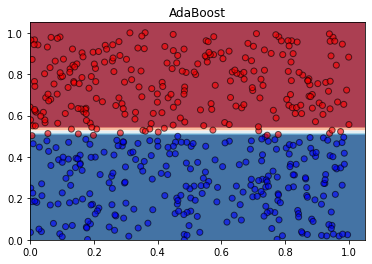

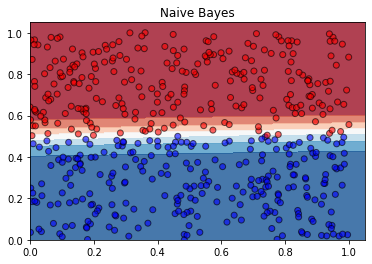

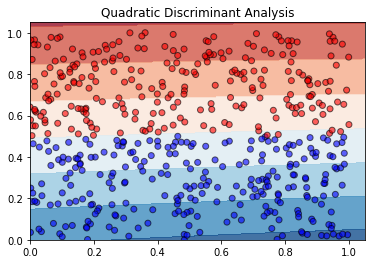

In [6]:
#Download the datasets to be trained against
datasets = downloadDatasets(["testDataset1", "testDataset2"])

#Create a filter and set its paths
ssmFilter = TestFilter()
ssmFilter.labelPath = ['scidata', 'system', 'facets', "SSM:REG:name:.*Chloroform.*", 'phase']
ssmFilter.featurePaths = []
ssmFilter.featurePaths.append(['scidata', 'dataset', 'dataseries', 'SSM:XY:axis:PEAK', 'valuearray', 'numberarray'])
ssmFilter.featurePaths.append(['scidata', 'dataset', 'dataseries', 'SSM:XY:axis:PEAK-LOC', 'valuearray', 'numberarray'])

#Get the labels for each dataset
labels = ssmFilter.getLabels(datasets)

#Get the data features for each dataset
features = ssmFilter.getFeatures(datasets)

#The minima for each feature
feature_mins = []

#THe maxima for each feature
feature_maxs = []

#Initialize the extrema
for f in features[0]:
    feature_mins.append(f)
    feature_maxs.append(f)
    
#Find the extrema for all features
for feature in features:
    for i in range(len(feature)):
        if feature[i] < feature_mins[i]:
            feature_mins[i] = feature[i]
        elif feature[i] > feature_maxs[i]:
            feature_maxs[i] = feature[i]
            
#Normalize all features into the range 0-1
for feature in features:
    for i in range(len(feature)):
        feature[i] = (feature[i] - feature_mins[i]) / (feature_maxs[i] - feature_mins[i]) 

#List of names of classifiers
names = ["Nearest Neighbors", "Support Vector Machine(Linear Kernel)", "Support Vector Machine (RBF Kernel)", 
         "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Quadratic Discriminant Analysis"]

#The classifiers to test
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

#Create a grid to graph
x_min, x_max = 0,1.1 #-500, 5000
y_min, y_max = 0,1.1 #20000, 55000
xx, yy = np.meshgrid(np.arange(x_min, x_max, .05),
                          np.arange(y_min, y_max, .05))

#Graph each classifier
for i in range(len(classifiers)):

    clf = classifiers[i]
    
    #Train the classifier on the features and labels
    clf.fit(features, labels)
    
    #Get the probability function over the grid
    if hasattr(clf, "decision_function"):
        zz = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        zz = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        
    #Plot the background probability
    zz = zz.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap=plt.cm.RdBu, alpha=.8)
    
    #Plot the data points
    plt.scatter([i[0] for i in features], [i[1] for i in features], c=['blue' if x == 'sub:solid' else 'red' for x in labels], cmap=ListedColormap(['#FF0000', '#0000FF']), alpha=0.6,
                edgecolors='k')
    
    plt.title(names[i])

    plt.show()